In [1]:
import numpy as np
import CellModeller
from CellModeller.Simulator import Simulator 

In [52]:
# Import data from pickle file
import cPickle
data = cPickle.load(open('/Users/timrudge/cellmodeller/data/ex1_simpleGrowth-17-11-22-01-23/step-00240.pickle','rb'))
cs = data['cellStates']

In [38]:
# Run a new simulation
model = '/Users/timrudge/Code/CellModeller4/Examples/ex1_simpleGrowth.py'
sim = Simulator(model, 0.025, clPlatformNum=0, clDeviceNum=0, saveOutput=True, pickleSteps=1)

Set up OpenCL context:
  Platform: Apple
  Device: Intel(R) Core(TM) i7-3820QM CPU @ 2.70GHz
Importing model ex1_simpleGrowth
Running in batch mode: no display will be output


In [39]:
for i in range(5):
    print "******************"
    print "Step ", i
    while not sim.step():
        pass
    cs = sim.cellStates
    for (id,cell) in cs.iteritems():
        print cell.pos
        print cell.vel
        print cell.length
        print "---"

******************
Step  0
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
3.5
---
******************
Step  1
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
3.5875
---
******************
Step  2
[-1.1666843, -2.0792184e-05, 0.0]
[-0.019809246, -2.0792184e-05, 0.0]
1.3829
---
[1.1674588, 2.1605176e-05, 0.0]
[0.020583749, 2.1605176e-05, 0.0]
1.29375
---
******************
Step  3
[-1.1828905, -4.1607414e-05, 0.0]
[-0.016206264, -2.0815231e-05, 0.0]
1.417
---
[1.1849563, 4.4078835e-05, 0.0]
[0.01749754, 2.247366e-05, 0.0]
1.32564
---
******************
Step  4
[-1.199114, -6.6414119e-05, 0.0]
[-0.016223431, -2.4806704e-05, 0.0]
1.45195
---
[1.2024865, 7.0883551e-05, 0.0]
[0.017530203, 2.6804715e-05, 0.0]
1.35832
---


In [53]:
# Make some convenient data arrays from cell properties
lengths = np.array([cell.length for (id,cell) in cs.iteritems()])
pos = np.array([cell.pos for (id,cell) in cs.iteritems()])
vel = np.array([cell.vel for (id,cell) in cs.iteritems()])
norm = np.array([cell.dir for (id,cell) in cs.iteritems()])

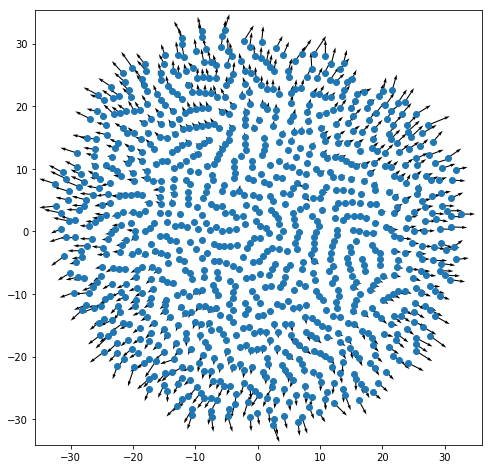

In [54]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

# Plot the position and orientation of each cell
plt.figure(figsize=(8,8))
plt.plot(pos[:,0], pos[:,1], 'o')
#plt.quiver(pos[:,0], pos[:,1], norm[:,0], norm[:,1])
plt.quiver(pos[:,0], pos[:,1], vel[:,0], vel[:,1])

In [63]:
sigma2 = 100.0

for (id,cell) in cs.iteritems():
    cell.localmeanvel = np.array([0,0,0])
    cell.totalweight = 0
    
for (id1,cs1) in cs.iteritems():
    cell.localmeanvel = np.array(cs1.vel)
    cell.totalweight = 1.0
    for (id2,cs2) in cs.iteritems():
        if id1<id2:
            r = np.array(cs1.pos) - np.array(cs2.pos)
            w = np.exp(-np.sum(r*r)/sigma2)
            
            cs1.localmeanvel = cs1.localmeanvel + np.array(cs2.vel)*w
            cs1.totalweight += w
            
            cs2.localmeanvel = cs2.localmeanvel + np.array(cs1.vel)*w
            cs2.totalweight += w

for (id,cell) in cs.iteritems():
    cell.localmeanvel = cell.localmeanvel/cell.totalweight
    
localmeanvel = np.array([cell.localmeanvel for (id,cell) in cs.iteritems()])

fluctuations = np.array([np.array(cell.vel)-cell.localmeanvel for (id,cell) in cs.iteritems()])
fluctuations.shape

(1014, 3)

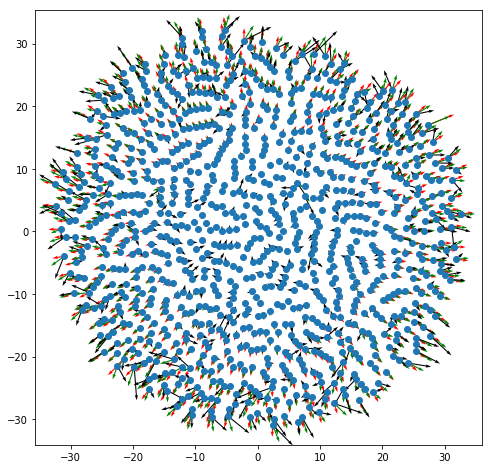

In [64]:
plt.figure(figsize=(8,8))
plt.plot(pos[:,0], pos[:,1], 'o')
plt.quiver(pos[:,0], pos[:,1], localmeanvel[:,0], localmeanvel[:,1], color='red')
plt.quiver(pos[:,0], pos[:,1], vel[:,0], vel[:,1], color='green')
plt.quiver(pos[:,0], pos[:,1], fluctuations[:,0], fluctuations[:,1], color='black')

(array([ 226.,  344.,  170.,  115.,   61.,   54.,   24.,    7.,    9.,    4.]),
 array([ 0.        ,  0.01721981,  0.03443963,  0.05165944,  0.06887926,
         0.08609907,  0.10331888,  0.1205387 ,  0.13775851,  0.15497833,
         0.17219814]),
 <a list of 10 Patch objects>)

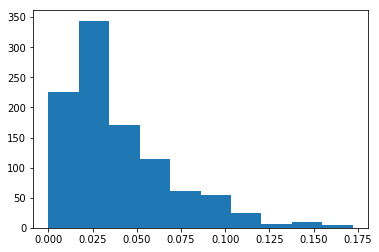

In [65]:
mf = np.sqrt(np.sum(fluctuations*fluctuations, axis=1))
plt.hist(mf)

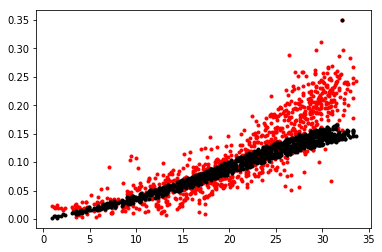

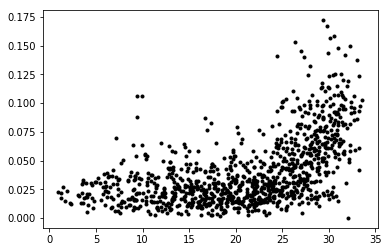

In [66]:
r = np.sqrt(pos[:,0]**2+pos[:,1]**2)
v = np.sqrt(vel[:,0]**2+vel[:,1]**2)
lmv = np.sqrt(localmeanvel[:,0]**2+localmeanvel[:,1]**2)
plt.plot(r, v, 'r.')
plt.plot(r, lmv, 'k.')

plt.figure()
plt.plot(r, mf, 'k.')